In [ ]:
%pip install -U openmim
!mim install mmcv-full

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 237 kB 54.8 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 43.7 MB 1.3 MB/s 
     |████████████████████████████████| 190 kB 32.6 MB/s 


In [ ]:
%pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 35.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
%pip install mmdet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 17.1 MB/s 


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -v -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 32369, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32369 (delta 8), reused 13 (delta 2), pack-reused 32338
Receiving objects: 100% (32369/32369), 41.88 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (23298/23298), done.
/content/mmdetection
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN

In [ ]:
import pandas as pd
import json
import mmcv
import numpy as np
import albumentations as A
import os
import cv2
from tqdm import tqdm
import re

/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


# Change data format (bounding circles to bounding boxes)

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
annotations = []

In [ ]:
train_path = '/content/drive/MyDrive/dataset/train/'
test_path = '/content/drive/MyDrive/dataset/test/'

### как будто по разному читает строку иногда

In [ ]:
def get_anno(data_path):
    bboxes_dict = {}
    annotations = []
    for idx in tqdm(df.index):
        record = df.loc[idx]
        anno = {'filename': record['ID_img']}
        image = mmcv.imread(f'{data_path}{record["ID_img"]}')
        anno['height'], anno['width'] = image.shape[:2]
        anno['ann'] = {}
        if df.loc[idx, 'count_region'] > 0:
            bounding_circles = [eval(elem) for elem in re.findall('{"cx":\d+,"cy":\d+,"r":\d+}', 
                                                                  df.loc[idx]['region_shape'])]
            anno['ann']['bboxes'] = np.array([[max(0, c['cx']-c['r']), max(0, c['cy']-c['r']),
                                               min(anno['width'], c['cx']+c['r']), min(anno['height'], c['cy']+c['r'])]
                                              for c in bounding_circles], dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([0 for _ in range(len(bounding_circles))], dtype=np.long)
            bboxes_dict[record['ID_img']] = [[max(0, c['cx']-c['r']), max(0, c['cy']-c['r']),
                                               min(anno['width'], c['cx']+c['r']), min(anno['height'], c['cy']+c['r'])]
                      for c in bounding_circles]
        else:
            anno['ann']['bboxes'] = np.array([], dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([], dtype=np.long)
        annotations.append(anno)
    return annotations, bboxes_dict

In [ ]:
"""[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]"""

"[\n    {\n        'filename': 'a.jpg',\n        'width': 1280,\n        'height': 720,\n        'ann': {\n            'bboxes': <np.ndarray> (n, 4),\n            'labels': <np.ndarray> (n, ),\n            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)\n            'labels_ignore': <np.ndarray> (k, 4) (optional field)\n        }\n    },\n    ...\n]"

In [ ]:
annotations, bboxes_dict = get_anno(train_path)

  0%|          | 8/5162 [00:00<01:06, 77.81it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
100%|██████████| 5162/5162 [01:48<00:00, 47.43it/s]


In [ ]:
annotations

# Upsample dataset

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ShiftScaleRotate(rotate_limit = 15, p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussNoise(p=0.5),
    A.Cutout(num_holes=5, max_h_size=200, max_w_size=200),
    A.RandomCropFromBorders(crop_left = 0.2, crop_right = 0.2, crop_top = 0.2, crop_bottom = 0.2, 
                            p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/dropout/cutout.py:51: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


In [ ]:
def upsample_dataset(data_path, transforms, bboxes_dict, annotations):
    new_annotations = annotations.copy()
    save_path = '/content/transformed_imgs/'
    for i in range(6):
        for img_name in tqdm(bboxes_dict.keys()):
            anno = {}
            image = cv2.imread(f'{data_path}{img_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transformed = transform(image=image, bboxes=bboxes_dict[img_name], 
                                    class_labels=['person' for _ in range(len(bboxes_dict[img_name]))])
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            cv2.imwrite(f'{data_path}{i}_{img_name}', transformed_image)
            anno['filename'] = f'{i}_{img_name}'
            anno['height'], anno['width'] = image.shape[:2]
            anno['ann'] = {}
            anno['ann']['bboxes'] = np.array(transformed_bboxes, dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([0 for _ in range(len(transformed_bboxes))], dtype=np.long)
            new_annotations.append(anno)
    return new_annotations

In [ ]:
new_annotations = upsample_dataset(train_path, transform, bboxes_dict, annotations)

  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 58/58 [01:47<00:00,  1.85s/it]


# Competetition dataset

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import numpy as np
from tqdm import tqdm

@DATASETS.register_module()
class AerialPhotoDataset(CustomDataset):
      CLASSES = ('Person', )
      transform = None
      test_mode = False
      def load_annotations(self, ann_file):
          annotations, bboxes_dict = get_anno(self.data_root)
          if not self.test_mode:
              annotations = upsample_dataset(self.data_root, self.transform, bboxes_dict, annotations)
          return annotations

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/dcn/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'AerialPhotoDataset'
cfg.data_root = '/content/drive/MyDrive/dataset/'

cfg.data.test.type = 'AerialPhotoDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/dataset/test/'
#cfg.data.test_mode = True
cfg.data.test.ann_file = '/content/train.csv' #???
cfg.data.path = test_path
cfg.data.test.img_prefix = ''

cfg.data.train.type = 'AerialPhotoDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/dataset/train/'
cfg.data.train.ann_file = '/content/train.csv' 
cfg.data.transform = transform
cfg.data.train.img_prefix = ''

# modify num classes of the model in box head
for layer in cfg.model.roi_head.bbox_head:
    layer.num_classes = 1
cfg.load_from = '/content/drive/MyDrive/models/model2.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/training_on_real_data'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 12
cfg.lr_config.warmup_ratio = 1e-4
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
cfg.runner.max_epochs = 6
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

  0%|          | 0/5162 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0%|          | 8/5162 [00:39<1:57:35,  1.37s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In 

In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=False)

2022-11-12 02:33:13,772 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-11-12 02:33:13,780 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/pretrained_models/ready_model.pth
2022-11-12 02:33:21,599 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-11-12 02:33:21,607 - root - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-11-12 02:33:21,613 - root - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-11-12 02:33:21,620 - root - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-11-12 02:33:21,628 - root - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-11-12 02:33:21,636 - root - INFO - DeformConv2dPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-11-12 02:33:21,645 - root - INFO - DeformConv2dPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-11-12 02:33:21,

# Inference model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from mmdet.apis import init_detector, inference_detector
from mmdet.models import build_detector
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
import torch

In [55]:
cfg.model.test_cfg.rcnn.score_thr = 0.3
cfg.model.test_cfg.rcnn.nms.iou_threshold = 0.40

In [ ]:
# Build the detector
model = init_detector(
    cfg, '/content/drive/MyDrive/models/model2.pth')

In [ ]:
def get_prediction(model, img_path):
    answer = []
    results = inference_detector(model, img_path)[0]
    probs = results[:, 4]
    if len(probs) == 1:
        return results
    else:
        for i in range(1, len(probs)):
            if i > 0 and probs[i] - probs[i-1] > 0.2:
                return results[:(i+1)]
        else:
            length = sum(probs > 0.3)
            return results[:length]
            

In [58]:
get_prediction(model, '/content/drive/MyDrive/dataset/test/3140.JPG')

array([[4.3348320e+03, 1.7789259e+03, 4.4989390e+03, 1.9423514e+03,
        6.8254691e-01],
       [3.5555261e+03, 2.2705542e+03, 3.7117271e+03, 2.4188215e+03,
        5.8875132e-01],
       [2.3885920e+03, 2.0100925e+03, 2.5405198e+03, 2.1605239e+03,
        3.2536161e-01]], dtype=float32)

In [59]:
bbox_to_bcircle(get_prediction(model, '/content/drive/MyDrive/dataset/test/3140.JPG'))

['{"cx":4416, "cy":1860, "r":81}',
 '{"cx":3633, "cy":2344, "r":76}',
 '{"cx":2464, "cy":2085, "r":75}']

In [ ]:
import pandas as pd
submission = pd.read_csv('/content/sample_solution.csv')
submission

In [ ]:
test_path = '/content/drive/MyDrive/dataset/test/'
results = []
for img_name in tqdm(submission['ID_img']):
    res = get_prediction(model, f'{test_path}{img_name}')
    results.append(res)

  5%|▍         | 156/3435 [00:44<14:57,  3.65it/s]

#bboxes to circles

In [ ]:
def bbox_to_bcircle(bboxes):
  brounds = []
  for bbox in bboxes:
    cx = int((bbox[0]+bbox[2])//2)
    cy = int((bbox[1]+bbox[3])//2)
    r = int((abs(bbox[2] - bbox[0]) + abs(bbox[3] - bbox[1])) // 4)
    #brounds.append({"cx":cx, "cy":cy, "r":r})
    brounds.append(f'{{"cx":{cx}, "cy":{cy}, "r":{r}}}')
  #return json.dumps(brounds, ensure_ascii=False, separators=(',',':'))
  return brounds

,ID_img,region_shape
0,1.JPG,0
1,2.JPG,0
2,3.JPG,0
3,4.JPG,0
4,5.JPG,0
...,...,...
3430,3431.JPG,0
3431,3432.JPG,0
3432,3433.JPG,0
3433,3434.JPG,0


In [63]:
results[3139:3142]

[array([], shape=(0, 5), dtype=float32),
 array([[3.7634666e+03, 2.7484941e+03, 3.9160144e+03, 2.9012485e+03,
         7.4938083e-01],
        [3.5970986e+03, 2.6564531e+03, 3.7739207e+03, 2.8407798e+03,
         7.1306247e-01],
        [3.8737361e+03, 2.8282400e+03, 4.0310896e+03, 2.9964333e+03,
         7.0725119e-01],
        [3.0359236e+03, 1.4277201e+03, 3.1994722e+03, 1.5818453e+03,
         6.8468440e-01],
        [3.7999934e+03, 2.2585901e+03, 3.9709724e+03, 2.4335662e+03,
         4.8312762e-01],
        [3.1416621e+03, 1.4895449e+03, 3.3658926e+03, 1.7132545e+03,
         4.6470946e-01],
        [3.5926792e+03, 2.1095017e+03, 3.7404736e+03, 2.2836572e+03,
         4.1694310e-01],
        [3.1590579e+03, 1.5063765e+03, 3.2857168e+03, 1.6301978e+03,
         3.3810475e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

In [ ]:
region_shape_column = [0 for x in range(submission.shape[0])]
for i in range(len(results)):
    if len(results[i]) != 0:
        region_shape_column[i]=bbox_to_bcircle(results[i])
submission["region_shape"] = region_shape_column

In [ ]:
submission

,ID_img,region_shape
0,1.JPG,0
1,2.JPG,0
2,3.JPG,0
3,4.JPG,0
4,5.JPG,0
...,...,...
3430,3431.JPG,0
3431,3432.JPG,0
3432,3433.JPG,0
3433,3434.JPG,0


In [ ]:
submission.to_csv('/content/submission2.csv', index=False)

#Vizualize predictions

In [ ]:
def vizualize_prediction(model, path):
    results = inference_detector(model, path)
    print(results)
    img = Image.open(path).convert('RGB')
    transform = transforms.PILToTensor()
    tensor = transform(img)
    transform = transforms.ToPILImage()
    result_img = transform(draw_bounding_boxes(tensor, torch.tensor([box[:4] for box in results[0]]), width=5))
    result_img = result_img.resize((1024,1024))
    display(result_img)

[array([[4.3348320e+03, 1.7789259e+03, 4.4989390e+03, 1.9423514e+03,
        6.8254691e-01],
       [3.5555261e+03, 2.2705542e+03, 3.7117271e+03, 2.4188215e+03,
        5.8875132e-01],
       [2.3885920e+03, 2.0100925e+03, 2.5405198e+03, 2.1605239e+03,
        3.2536161e-01]], dtype=float32)]


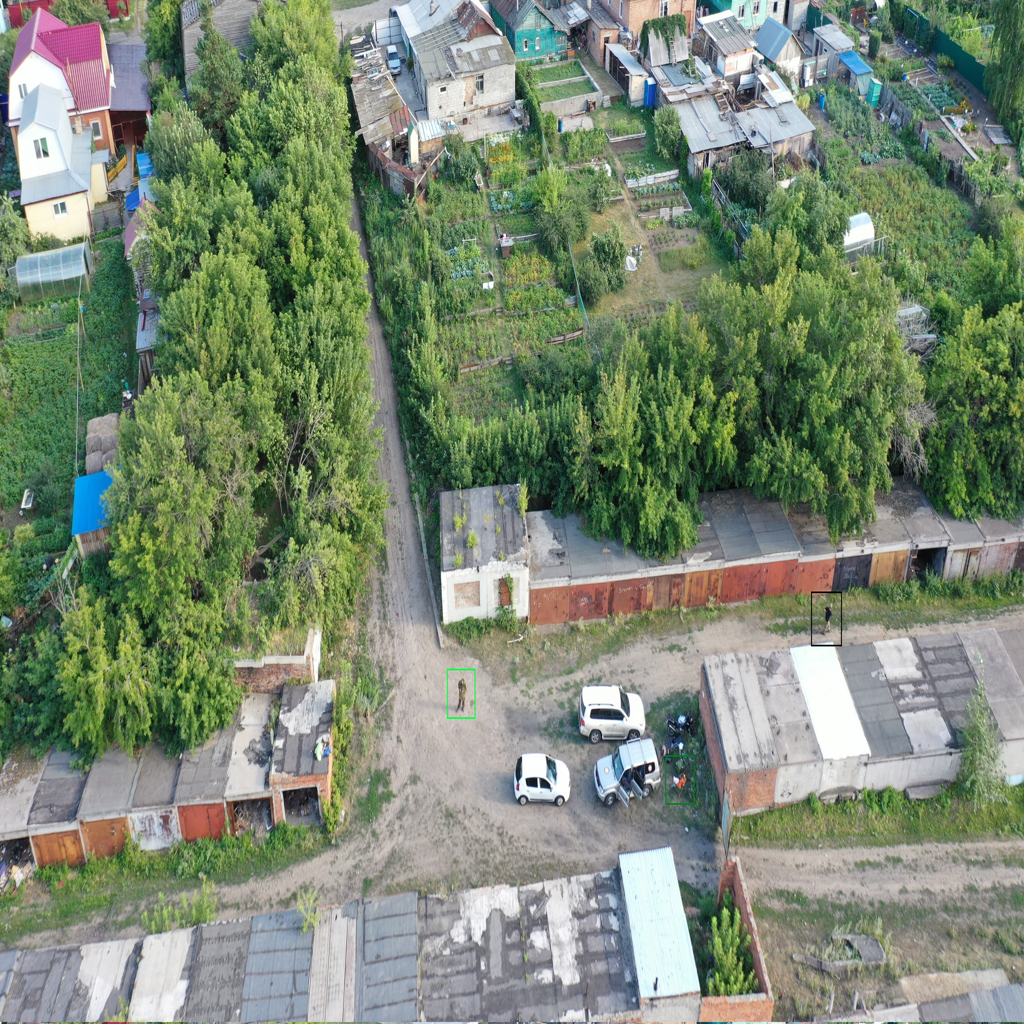

In [57]:
vizualize_prediction(model, '/content/drive/MyDrive/dataset/test/3140.JPG')